In [1]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 40000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Nita O'Hara,F,SBD,Wraps,28.0,24-34,F-OR,82.40,82.5,140.0,...,390.0,3,351.21,351.21,307.45,600.72,NaN,NaN,GPC-AUS,2018-10-27
1,Callum Pearce,M,SBD,Wraps,24.0,24-34,M-OR,98.80,100,260.0,...,730.0,3,446.45,446.45,429.22,665.24,NaN,Australia,GPC-AUS,2018-10-27
2,Jenn Schooten,F,SBD,Wraps,33.0,24-34,F-OR,97.20,90+,125.0,...,370.0,9,310.76,310.76,267.90,535.51,NaN,Australia,GPC-AUS,2015-05-19
3,Laura Sgro,F,SBD,Wraps,24.0,24-34,F-OR,57.90,60,135.0,...,380.0,4,435.58,435.58,385.05,687.84,NaN,Australia,GPC-AUS,2015-05-19
4,Lauren Adams,F,SBD,Wraps,24.0,24-34,F-OR,65.20,67.5,75.0,...,260.0,16,272.15,272.15,240.20,439.45,NaN,NaN,GPC-AUS,2015-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Michael Pereira,M,SBD,Wraps,20.0,20-23,jr,66.00,67.5,0.0,...,500.0,1,392.60,404.38,381.49,574.05,Yes,USA,NASA,2020-02-22
39996,Dominic Frisillo,M,SBD,Wraps,22.5,20-23,jr,77.75,82.5,0.0,...,502.5,1,349.43,349.43,337.11,509.20,Yes,USA,NASA,2020-02-22
39997,Robert McKinzie,M,D,Raw,58.5,55-59,dlpure,119.25,125,0.0,...,227.5,1,130.99,169.10,125.51,445.80,Yes,USA,NASA,2020-02-22
39998,Willie Agnew,M,SBD,Wraps,56.5,55-59,m2,89.81,90,0.0,...,615.0,1,393.04,489.72,376.72,581.81,Yes,USA,NASA,2019-10-05


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              2310
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [6]:
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,F,SBD,Wraps,28.0,82.40,150.0,65.0,175.0,351.21
1,M,SBD,Wraps,24.0,98.80,282.5,170.0,277.5,446.45
2,F,SBD,Wraps,33.0,97.20,140.0,70.0,160.0,310.76
3,F,SBD,Wraps,24.0,57.90,150.0,95.0,135.0,435.58
4,F,SBD,Wraps,24.0,65.20,95.0,45.0,120.0,272.15
...,...,...,...,...,...,...,...,...,...
39990,M,SBD,Raw,44.5,97.07,160.0,165.0,205.0,326.56
39991,F,SBD,Wraps,27.5,88.45,107.5,47.5,147.5,263.32
39995,M,SBD,Wraps,20.0,66.00,190.0,97.5,212.5,392.60
39996,M,SBD,Wraps,22.5,77.75,182.5,105.0,215.0,349.43


In [7]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,0,1,28.0,82.40,150.0,65.0,175.0,351.21
1,1,1,24.0,98.80,282.5,170.0,277.5,446.45
2,0,1,33.0,97.20,140.0,70.0,160.0,310.76
3,0,1,24.0,57.90,150.0,95.0,135.0,435.58
4,0,1,24.0,65.20,95.0,45.0,120.0,272.15
...,...,...,...,...,...,...,...,...
39990,1,0,44.5,97.07,160.0,165.0,205.0,326.56
39991,0,1,27.5,88.45,107.5,47.5,147.5,263.32
39995,1,1,20.0,66.00,190.0,97.5,212.5,392.60
39996,1,1,22.5,77.75,182.5,105.0,215.0,349.43


In [9]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [12]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

model = LinearRegression()

In [14]:
model.fit(S_train, s_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
S_pred = model.predict(S_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(S_pred , s_test))

R2-score: 0.92


In [16]:
model.fit(B_train, b_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
B_pred = model.predict(B_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(B_pred , b_test))

R2-score: 0.86


In [18]:
model.fit(D_train, d_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
D_pred = model.predict(D_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(D_pred , d_test))

R2-score: 0.89


In [20]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

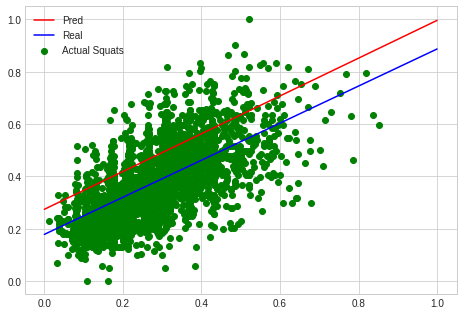

In [83]:
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, s_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats')
plt.plot(xfit, yfit, '-r', color='red', label='Pred')
plt.plot(xfit, zfit, '-r', color='blue', label='Real')
ax.legend()
ax.grid(True)
plt.show()

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

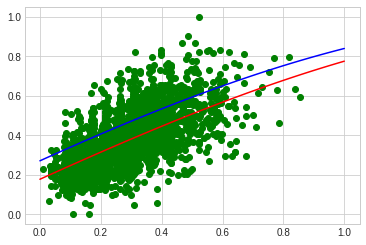

In [90]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 1)
ax.plot(xfit, np.sin(zfit), color = 'r');
ax.plot(xfit, np.sin(yfit), color = 'b');
ax.scatter(S_bw, s_test, color = 'g')